In [57]:
import pickle
from glob import iglob
import numpy as np
import librosa
from shutil import rmtree
from constants import *

DATA_AUDIO_DIR = '../test_train_data'
list_dir = os.listdir(DATA_AUDIO_DIR)
list_dir.sort()

OUTPUT_DIR = '../output'
OUTPUT_DIR_TRAIN = os.path.join(OUTPUT_DIR, 'train')
OUTPUT_DIR_TEST = os.path.join(OUTPUT_DIR, 'test')


PAD_SIZE = 10000
TARGET_SR = 22050
AUDIO_LENGTH = TARGET_SR * 10
SEGMENT_NUM = 2

In [58]:
def mkdir_p(path):
    import errno
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise


def del_folder(path):
    try:
        rmtree(path)
    except:
        pass

### Delete pickle file & Make directory

In [59]:
# del_folder(OUTPUT_DIR_TRAIN)
# del_folder(OUTPUT_DIR_TEST)
# mkdir_p(OUTPUT_DIR_TRAIN)
# mkdir_p(OUTPUT_DIR_TEST)

In [77]:
order = 0
list_dir.sort()
class_ids = {list_dir[i]: i for i in range(len(list_dir))}

def extract_class_id(wav_filename):
    return class_ids.get(wav_filename.split('/')[2])

def read_audio_from_filename(filename, target_sr):
    audio, _ = librosa.load(filename, sr=TARGET_SR, mono=True)
    audio = audio.reshape(-1, 1)
    return audio


def convert_data():

    for i, wav_filename in enumerate(iglob(os.path.join(DATA_AUDIO_DIR, '**/**.wav'), recursive=True)):
        class_id = extract_class_id(wav_filename)
        audio_buf = read_audio_from_filename(wav_filename, target_sr=TARGET_SR)
        
        # normalize mean 0, variance 1
        audio_buf = (audio_buf - np.mean(audio_buf)) / np.std(audio_buf)
        original_length = len(audio_buf)
        print(i, wav_filename, original_length, np.round(np.mean(audio_buf), 4), np.std(audio_buf))
        
        voice_seg = []
        if original_length > AUDIO_LENGTH * SEGMENT_NUM + PAD_SIZE:
            first_seg = audio_buf[PAD_SIZE : AUDIO_LENGTH + PAD_SIZE]
            second_seg = audio_buf[AUDIO_LENGTH+PAD_SIZE+1 : PAD_SIZE+AUDIO_LENGTH*2+1]
            
            voice_seg.append(first_seg)
            voice_seg.append(second_seg)
            print(len(first_seg),len(second_seg))
        elif original_length > AUDIO_LENGTH + PAD_SIZE:
            first_seg = audio_buf[PAD_SIZE : AUDIO_LENGTH + PAD_SIZE]
            voice_seg.append(first_seg)
            print('Drop 1 Segment, Audio length={}'.format(len(audio_buf)))
        else:
            print('Drop 2 Segment, Audio length={}'.format(len(audio_buf)))
            

        output_folder = OUTPUT_DIR_TRAIN
        if wav_filename[-5:] == '5.wav':
            output_folder = OUTPUT_DIR_TEST

        output_filename = os.path.join(output_folder, str(wav_filename[19:-4]).replace('/', '_') + '.pkl')
        out_segs = []
        for i_seg, audio_seg in enumerate(voice_seg) :
            out = {'class_id': class_id,
               'audio': audio_seg,
               'sr': TARGET_SR}
            
            with open(str(output_filename+"_"+str(i_seg)), 'wb') as w:
                pickle.dump(out, w)

            print(str(output_filename+"_"+str(i_seg)))
        
        print("-----------------")
      

### Convert Data

In [3]:
# convert_data()

In [61]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Lambda, Bidirectional, LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow import convert_to_tensor
from tensorflow import expand_dims
import numpy as np
import pickle
import os
from glob import glob
import tensorflow

print(tensorflow.__version__)

2.1.0


In [64]:
DATA_AUDIO_DIR = '../test_train_data'
list_dir = os.listdir(DATA_AUDIO_DIR)
list_dir.sort()

class_ids = {list_dir[i]: i for i in range(len(list_dir))}

In [65]:
def m5(num_classes):
    print("Class Num", num_classes)
    print('Using Model M5')
    m = Sequential()
    m.add(Conv1D(128,
                 input_shape=[AUDIO_LENGTH, 1],
                 kernel_size=80,
                 strides=4,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(l=0.0001)))
    m.add(BatchNormalization())
    m.add(Activation('relu'))
    m.add(MaxPooling1D(pool_size=4, strides=None))
    m.add(Conv1D(128,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(l=0.0001)))
    m.add(BatchNormalization())
    m.add(Activation('relu'))
    m.add(MaxPooling1D(pool_size=4, strides=None))
    m.add(Conv1D(256,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(l=0.0001)))
    m.add(BatchNormalization())
    m.add(Activation('relu'))
    m.add(MaxPooling1D(pool_size=4, strides=None))
    m.add(Conv1D(512,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(l=0.0001)))
    m.add(BatchNormalization())
    m.add(Activation('relu'))
    m.add(MaxPooling1D(pool_size=4, strides=None))
    m.add(Lambda(lambda x: K.mean(x, axis=1)))  # Same as GAP for 1D Conv Layer
    m.add(Dense(num_classes, activation='softmax'))
    return m


def get_data(file_list):
    def load_into(_filename, _x, _y):
        with open(_filename, 'rb') as f:
            audio_element = pickle.load(f)
            _x.append(audio_element['audio'])
            _y.append(int(audio_element['class_id']))

    x, y = [], []
    for filename in file_list:
        load_into(filename, x, y)
    return np.array(x), np.array(y)


In [ ]:
num_classes = len(list_dir)
model = m5(num_classes)

if model is None:
    exit('Something went wrong!!')

model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
print(model.summary())

In [66]:
train_files = glob(os.path.join(OUTPUT_DIR_TRAIN, '**.pkl_*'))
print(os.path.join(OUTPUT_DIR_TRAIN, '**.pkl_*'))
x_tr, y_tr = get_data(train_files)
y_tr = to_categorical(y_tr, num_classes=num_classes)

test_files = glob(os.path.join(OUTPUT_DIR_TEST, '**.pkl_*'))
x_te, y_te = get_data(test_files)
y_te = to_categorical(y_te, num_classes=num_classes)

print('x_tr.shape =', x_tr.shape)
print('y_tr.shape =', y_tr.shape)
print('x_te.shape =', x_te.shape)
print('y_te.shape =', y_te.shape)
print(type(x_te))

# if the accuracy does not increase over 10 epochs, reduce the learning rate by half.
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00005, verbose=1)
batch_size = 128
history = model.fit(x=x_tr, y=y_tr, batch_size=16, epochs=100, verbose=2, shuffle=True, validation_data=(x_te, y_te), callbacks=[reduce_lr])


# epoch 500 audio_length 10000 min_lr 0.0001 sr 8000 batch_size 16 : val_acc 0.73
# epoch 500 audio_length 10000 min_lr 0.00005 sr 8000 batch_size 16 : val_acc 0.77(0.83)
# epoch 50 audio_length 20000 min_lr 0.00005 sr 8000 batch_size 16 : val_acc 0.90
# epoch 100 audio_length 20000 min_lr 0.00005 sr 8000 batch_size 16 : val_acc 0.93
# epoch 100 audio_length 20000 min_lr 0.00005 sr 8000 batch_size 32 : val_acc 0.89(0.90) predict 0.75
# epoch 150 audio_length 20000 min_lr 0.00005 sr 8000 batch_size 16 : val_acc 0.91 predict 0.75

Class Num 130
Using Model M5
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 55125, 128)        10368     
_________________________________________________________________
batch_normalization_8 (Batch (None, 55125, 128)        512       
_________________________________________________________________
activation_8 (Activation)    (None, 55125, 128)        0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 13781, 128)        0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 13781, 128)        49280     
_________________________________________________________________
batch_normalization_9 (Batch (None, 13781, 128)        512       
_________________________________________________________________
activation_9 (Activation)

Epoch 50/100
1024/1024 - 13s - loss: 0.0879 - accuracy: 0.9834 - val_loss: 0.1186 - val_accuracy: 0.9766
Epoch 51/100
1024/1024 - 13s - loss: 0.0864 - accuracy: 0.9824 - val_loss: 0.1203 - val_accuracy: 0.9766
Epoch 52/100
1024/1024 - 13s - loss: 0.0852 - accuracy: 0.9854 - val_loss: 0.1180 - val_accuracy: 0.9766
Epoch 53/100
1024/1024 - 13s - loss: 0.0858 - accuracy: 0.9795 - val_loss: 0.1174 - val_accuracy: 0.9766
Epoch 54/100
1024/1024 - 13s - loss: 0.0831 - accuracy: 0.9805 - val_loss: 0.1160 - val_accuracy: 0.9766
Epoch 55/100
1024/1024 - 13s - loss: 0.0844 - accuracy: 0.9805 - val_loss: 0.1186 - val_accuracy: 0.9766
Epoch 56/100
1024/1024 - 13s - loss: 0.0826 - accuracy: 0.9844 - val_loss: 0.1155 - val_accuracy: 0.9766
Epoch 57/100
1024/1024 - 13s - loss: 0.0827 - accuracy: 0.9814 - val_loss: 0.1132 - val_accuracy: 0.9727
Epoch 58/100

Epoch 00058: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1024/1024 - 13s - loss: 0.0799 - accuracy: 0.9834 - val_loss: 0.11

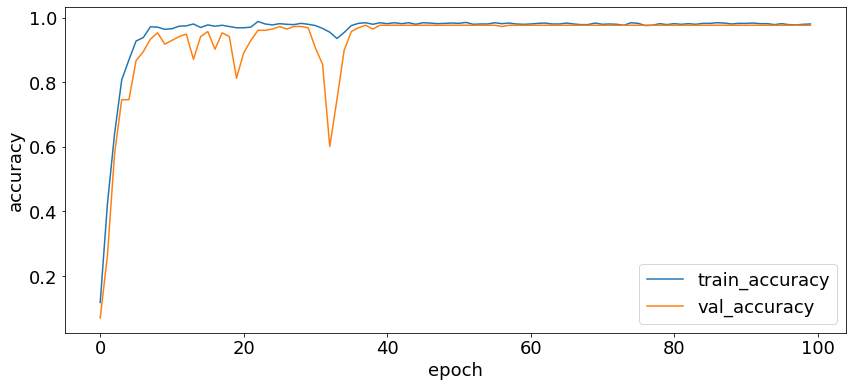

In [68]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.rc('font', size=18)

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

In [73]:
import pickle
from glob import iglob
import numpy as np
import librosa
from shutil import rmtree
from constants import *


OUTPUT_VAL_DIR = '../output_val'
OUTPUT_DIR_VAL_TRAIN = os.path.join(OUTPUT_VAL_DIR, 'train')
OUTPUT_DIR_VAL_TEST = os.path.join(OUTPUT_VAL_DIR, 'test')

DATA_AUDIO_VAL_DIR = '../test_val_data'
DATA_AUDIO_DIR = '../test_train_data'

del_folder(OUTPUT_DIR_VAL_TRAIN)
del_folder(OUTPUT_DIR_VAL_TEST)
mkdir_p(OUTPUT_DIR_VAL_TRAIN)
mkdir_p(OUTPUT_DIR_VAL_TEST)


In [74]:
PAD_SIZE = 10000
TARGET_SR = 22050
AUDIO_LENGTH = TARGET_SR * 10
SEGMENT_NUM = 2

In [75]:
def convert_val_data():
    
    
    for i, wav_filename in enumerate(iglob(os.path.join(DATA_AUDIO_VAL_DIR, '**/**.wav'), recursive=True)):
        class_id = extract_class_id(wav_filename)
        audio_buf = read_audio_from_filename(wav_filename, target_sr=TARGET_SR)
        
        # normalize mean 0, variance 1
        audio_buf = (audio_buf - np.mean(audio_buf)) / np.std(audio_buf)
        original_length = len(audio_buf)
        print(i, wav_filename, original_length, np.round(np.mean(audio_buf), 4), np.std(audio_buf))
        
        voice_seg = []
        if original_length > AUDIO_LENGTH * SEGMENT_NUM + PAD_SIZE:
            first_seg = audio_buf[PAD_SIZE : AUDIO_LENGTH + PAD_SIZE]
            second_seg = audio_buf[AUDIO_LENGTH+PAD_SIZE+1 : PAD_SIZE+AUDIO_LENGTH*2+1]
            
            voice_seg.append(first_seg)
            voice_seg.append(second_seg)
            print(AUDIO_LENGTH,len(first_seg),len(second_seg))
        elif original_length > AUDIO_LENGTH + PAD_SIZE:
            first_seg = audio_buf[PAD_SIZE : AUDIO_LENGTH + PAD_SIZE]
            voice_seg.append(first_seg)
            print('Drop 1 Segment, Audio length={}'.format(len(audio_buf)))
        else:
            print('Drop 2 Segment, Audio length={}'.format(len(audio_buf)))
            

        output_folder = OUTPUT_DIR_VAL_TRAIN
        if wav_filename[-5:] == '5.wav':
            output_folder = OUTPUT_DIR_VAL_TEST

        output_filename = os.path.join(output_folder, str(wav_filename[19:-4]).replace('/', '_') + '.pkl')
        out_segs = []
        for i_seg, audio_seg in enumerate(voice_seg) :
            out = {'class_id': class_id,
               'audio': audio_seg,
               'sr': TARGET_SR}
            
            with open(str(output_filename+"_"+str(i_seg)), 'wb') as w:
                pickle.dump(out, w)

            print(str(output_filename+"_"+str(i_seg)))
        
        print("-----------------")

if __name__ == '__main__':
    convert_val_data()

0 ../test_val_data/2017019880001_kimsubin/12.wav 448762 -0.0 0.9999999
Drop 1 Segment, Audio length=448762
../output_val/train/17019880001_kimsubin_12.pkl_0
-----------------
1 ../test_val_data/2017019880001_kimsubin/5.wav 479744 0.0 1.0
220500 220500 220500
../output_val/test/17019880001_kimsubin_5.pkl_0
../output_val/test/17019880001_kimsubin_5.pkl_1
-----------------
2 ../test_val_data/2017019880001_kimsubin/4.wav 484864 -0.0 1.0
220500 220500 220500
../output_val/train/17019880001_kimsubin_4.pkl_0
../output_val/train/17019880001_kimsubin_4.pkl_1
-----------------
3 ../test_val_data/2017019880001_kimsubin/8.wav 471341 0.0 1.0
220500 220500 220500
../output_val/train/17019880001_kimsubin_8.pkl_0
../output_val/train/17019880001_kimsubin_8.pkl_1
-----------------
4 ../test_val_data/2017019880001_kimsubin/6.wav 494048 -0.0 1.0
220500 220500 220500
../output_val/train/17019880001_kimsubin_6.pkl_0
../output_val/train/17019880001_kimsubin_6.pkl_1
-----------------
5 ../test_val_data/201701

In [94]:
from sklearn.metrics import accuracy_score

val_files = glob(os.path.join(OUTPUT_DIR_VAL_TRAIN, '**.pkl_*'))
val_files.sort()

x_val, y_val = get_data(val_files)
print('y_val : ', y_val)
print(x_val.shape, y_val.shape)
pred_out = model.predict(x_val)

real =[]
pred_out_idex=[]

list_dir = os.listdir(DATA_AUDIO_DIR)
list_dir.sort()

j = 0
for i,pred in enumerate(pred_out) :
    if np.argmax(pred) != y_val[i]:
        print('\033[31m'+"Predict :"+str(list_dir[np.argmax(pred)])+" , Real :"+str(list_dir[y_val[i]])+", Likelihood :"+str(np.max(pred)))
    else:
        print('\033[30m'+"Predict :"+str(list_dir[np.argmax(pred)])+" , Real :"+str(list_dir[y_val[i]])+", Likelihood :"+str(np.max(pred)))
    real.append(list_dir.index(list_dir[y_val[i]]))
    pred_out_idex.append(np.argmax(pred))
    
# get the accuracy
print ('\n\033[30m'+"Final Predict Likelihood : "+format(accuracy_score(real, pred_out_idex)*100, ".4f"))

y_val :  [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13 13 13
 13 13 13 13 13 28 28 43 43 43 43 43 43 43 43 43 43 43 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83]
(61, 220500, 1) (61,)
Predict :2017019740001_kwakjuheon , Real :2017019740001_kwakjuheon, Likelihood :0.9950205
Predict :2017019740001_kwakjuheon , Real :2017019740001_kwakjuheon, Likelihood :0.99978393
Predict :2017019770007_simseungmin , Real :2017019740001_kwakjuheon, Likelihood :0.3145155
Predict :2017019770037_jeonghojun , Real :2017019740001_kwakjuheon, Likelihood :0.9567083
Predict :2017019770037_jeonghojun , Real :2017019740001_kwakjuheon, Likelihood :0.97216034
Predict :2017019770037_jeonghojun , Real :2017019740001_kwakjuheon, Likelihood :0.9904141
Predict :2017019770037_jeonghojun , Real :2017019740001_kwakjuheon, Likelihood :0.9610421
Predict :2017019770037_jeonghojun , Real :2017019740001_kwakjuheon, Likelihood :0.9729436
Predict :2017019740001_kwakjuheon , Real :2017019740001_kwa